# Example: Bimodular rod
A complete 1D analysis implementation for rod problems. This code implements the full IGA workflow for 1D linear elasticity problems
including material heterogeneity, boundary conditions, and multi-level refinement.

## Step 1: Initialize

In [1]:
# Initialize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import numpy.linalg as la
from src.containers import Knotvector
from src.spaces import BSplineSpace
from src.piecewise import Function, Branch, Rational, Polynomial
import matplotlib.pylab as plt

## Step 2: Define the Young's modulus

Young's modulus function representing heterogeneous material properties.

This piecewise function defines a composite material with two distinct regions:
- High stiffness material (200 GPa) on the interval [0, 0.5)
- Low stiffness material (10 GPa) on the interval [0.5, 1.0)

The discontinuity at x=0.5 models a material interface where mechanical
properties change abruptly, typical in composite structures or multi-material systems.


In [2]:
E = Function([
    Branch(numerator=Polynomial([200.e9]), support=(0., 0.5), includes_right_boundary=False),
    Branch(numerator=Polynomial([10.e9]), support=(0.5, 1.0), includes_right_boundary=True)])

## Step 3: Applied Load
Applied distributed load function.

This represents a constant distributed load of 1000 N/m applied uniformly
along the entire length of the rod [0, 1]. The load is positive, indicating
tensile loading in the positive x-direction.


In [3]:
P = Function(Branch(numerator=Polynomial([1000.]), support=(0., 1)))

## Step 4: Solution in Coarse scale

### Step 4.1: Basis functions

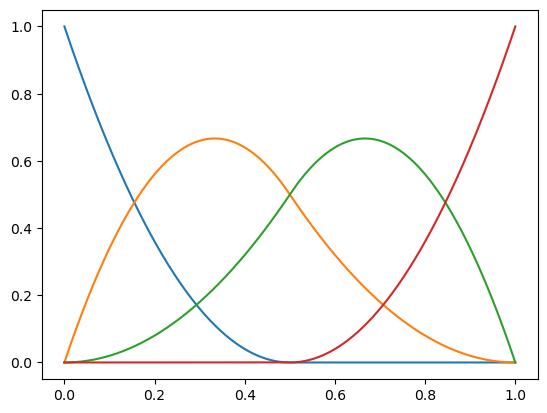

In [4]:
# Coarse knot vector for quadratic B-spline discretization.
T0x = Knotvector(degree=2, domain=(0,1), name="T0x").refine()

# Coarse B-spline function space for the approximation.
V0x = BSplineSpace(T0x, name="V0x")

# First derivative space of the coarse B-spline basis.
D1V0x = V0x.diff()

# Second derivative space of the coarse B-spline basis.
D2V0x = V0x.diff(2)

# Number of basis functions in the coarse space.
nr_basis_functions = V0x.nr_items

# Plot of all B-spline basis functions in the coarse space.
x = np.linspace(0,1, 1000)
for i in np.arange(nr_basis_functions):
    plt.plot(x, V0x.items[i](x))

### Step 4.2: Stifness matrix, load vector

In [5]:
# Coarse stiffness matrix for the heterogeneous rod problem.
# Kcc[i,j] = ∫₀¹ E(x) * (dB_i/dx) * (dB_j/dx) dx
Kcc = np.zeros(shape=(nr_basis_functions, nr_basis_functions))

for i in np.arange(nr_basis_functions):
    for j in np.arange(nr_basis_functions):
        Kcc[i, j] = (E*D1V0x.items[i] * D1V0x.items[j]).integral(0, 1)[0]
        
# Coarse load vector for the distributed loading.
# Fc[i] = ∫₀¹ B_i(x) * P(x) dx
Fc = np.zeros(shape=nr_basis_functions, dtype=float)
for i in np.arange(nr_basis_functions):
    Fc[i] =  (V0x.items[i] * P).integral(0,1)[0]
    
# Apply boundary conditions - Fix Left end (x=0)
Kcc = np.delete(Kcc, [0], axis=0)
Kcc = np.delete(Kcc, [0], axis=1)
Fc = np.delete(Fc,[0])

### Step 4.3: Solution and recovery

In [6]:
def recover(v: BSplineSpace, a: np.ndarray):
    """
    Reconstruct a function from its B-spline coefficients.
    
    Computes the linear combination of B-spline basis functions weighted
    by the coefficient vector a. This operation reconstructs the approximate
    solution from the discrete finite element coefficients.
    
    Parameters
    ----------
    v : BSplineSpace
        B-spline function space containing the basis functions.
    a : ndarray
        Coefficient vector of length v.nr_items.
        
    Returns
    -------
    Function
        Reconstructed function: u(x) = Σ a_i * B_i(x)
        
    Examples
    --------
    >>> a = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    >>> u = recover(V0x, a)
    >>> u(0.5)  # Evaluate reconstructed function at midpoint
    0.3  # Example value
    
    Notes
    -----
    - Implements the standard finite element reconstruction
    - Result is a Function object that can be evaluated anywhere
    - Essential for post-processing and visualization
    """
    nr_funcs = v.nr_items
    y = a[0] * v.items[0]
    for i in np.arange(1, nr_funcs):
        y = y + a[i] * v.items[i]
    return y

# Solution vector reconstruction after boundary conditions.
ac = np.concatenate([np.asarray(0.), la.solve(Kcc, Fc)], axis=None)
uc = recover(V0x, ac)

### Step 4.4: Plot solution

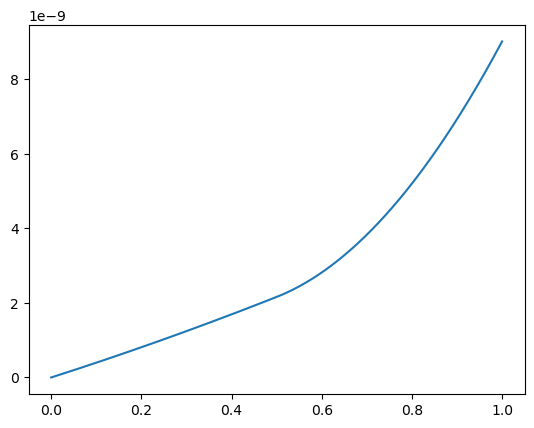

In [7]:
plt.figure()
x = np.linspace(0,1, 1000)
plt.plot(x, uc(x))
plt.show()

## Step 5: Solution in Fine scale
This step employs an enriched approximation space rather than conventional hierarchical refinement, utilizing a substantially finer basis to achieve improved solution accuracy.

### Step 5.1: Basis functions

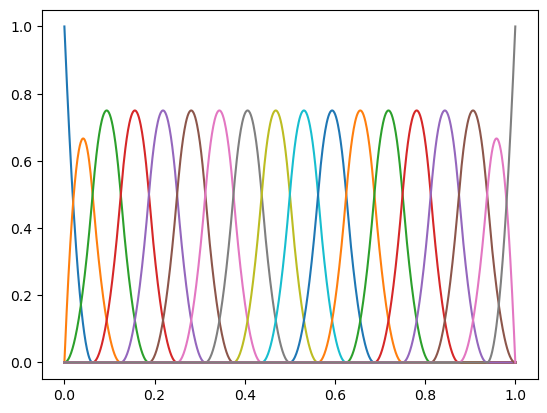

In [8]:
# Fine knot vector for quadratic B-spline discretization. It obtained by refining the coarse knotvector.
T1x = T0x.refine(nr_times=3, copy=True, name="fine knotvector")

# Fine B-spline function space for the approximation.
V1x = BSplineSpace(T1x, name="V1x")

# First derivative space of the fine B-spline basis.
D1V1x = V1x.diff()

# Second derivative space of the fine B-spline basis.
D2V1x = V1x.diff(2)

# Number of basis functions in the coarse space.
nr_basis_functions_fine = V1x.nr_items

# Plot of all B-spline basis functions in the coarse space.
x = np.linspace(0,1, 1000)
for i in np.arange(nr_basis_functions_fine):
    plt.plot(x, V1x.items[i](x))

### Step 5.2: Stifness matrix, load vector

In [9]:
# Fine stiffness matrix for the heterogeneous rod problem.
# Kff[i,j] = ∫₀¹ E(x) * (dB_i/dx) * (dB_j/dx) dx
Kff = np.zeros(shape=(nr_basis_functions_fine, nr_basis_functions_fine))

for i in np.arange(nr_basis_functions_fine):
    for j in np.arange(nr_basis_functions_fine):
        Kff[i, j] = (E*D1V1x.items[i] * D1V1x.items[j]).integral(0, 1)[0]
        
# Fine load vector for the distributed loading.
# Ff[i] = ∫₀¹ B_i(x) * P(x) dx
Ff = np.zeros(shape=nr_basis_functions_fine, dtype=float)
for i in np.arange(nr_basis_functions_fine):
    Ff[i] =  (V1x.items[i] * P).integral(0,1)[0]
    
# Apply boundary conditions - Fix Left end (x=0)
Kff = np.delete(Kff, [0], axis=0)
Kff = np.delete(Kff, [0], axis=1)
Ff = np.delete(Ff,[0])

### Step 5.3: Solution and recovery

In [10]:
# Solution vector reconstruction after boundary conditions.
af = np.concatenate([np.asarray(0.), la.solve(Kff, Ff)], axis=None)
uf = recover(V1x, af)

### Step 5.4: Plot Solution

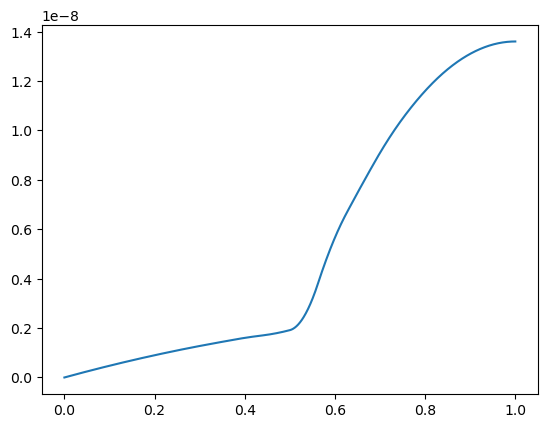

In [11]:
plt.figure()
x = np.linspace(0,1, 1000)
plt.plot(x, uf(x))
plt.show()

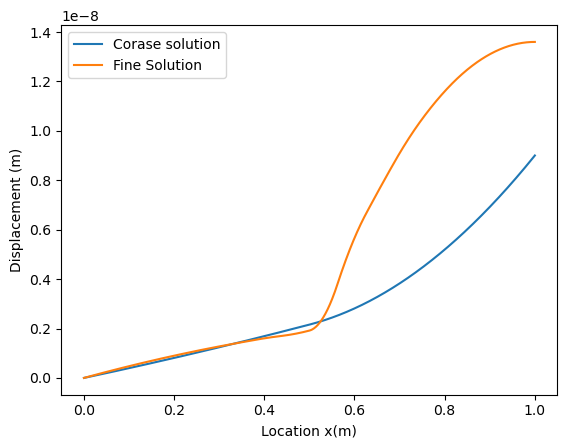

In [12]:
# Compare solutions
plt.plot(x, uc(x), label="Corase solution")
plt.plot(x, uf(x), label="Fine Solution")
plt.xlabel("Location x(m)")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()

## Recover Analytic Expression for Solution

In [14]:
from IPython.display import display, Math
print("Corase solution:\tx 1e9")
display(Math((uc*1e9).to_latex('x')))

print("\nFine solution:\tx 1e9")
display(Math((uf*1e9).to_latex('x')))


Corase solution:	x 1e9


<IPython.core.display.Math object>


Fine solution:	x 1e9


<IPython.core.display.Math object>